In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torch.nn.functional as F

# Convert to tensor and normalize between -1 and 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 128
channels = 1
height = 28
width = 28

# Load mnist
mnist = MNIST('./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=False)
image = next(iter(data_loader))[0][0]
print(image.shape)

torch.Size([1, 28, 28])


In [37]:
T = 200
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def cosine_beta_schedule_alphas(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    return alphas_cumprod


def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

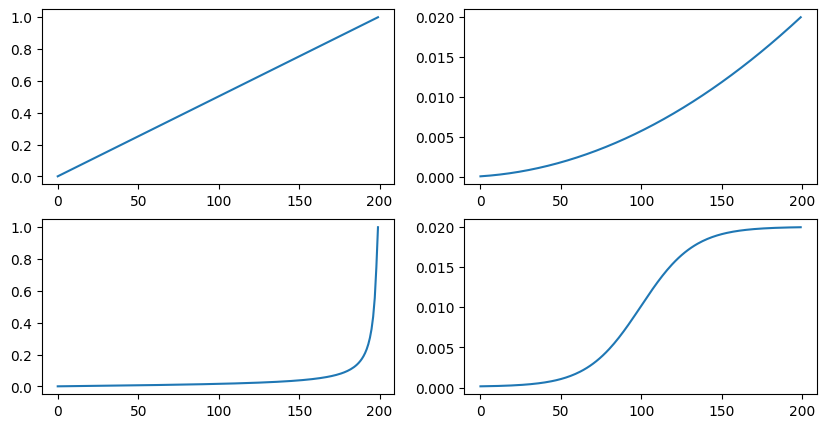

In [33]:
import matplotlib.pyplot as plt

betas_lin = linear_beta_schedule(T)
betas_cos = cosine_beta_schedule(T)
betas_quad = quadratic_beta_schedule(T)
betas_sig = sigmoid_beta_schedule(T)

fig, ax = plt.subplots(2, 2, figsize=(10, 5))
ax[0][0].plot(betas_lin)
ax[1][0].plot(betas_cos)
ax[0][1].plot(betas_quad)
ax[1][1].plot(betas_sig)

In [34]:
def get_constants(betas):
  alphas = 1.0 - betas
  alphas_cumprod = torch.cumprod(alphas, dim=0)
  alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
  sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

  sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
  sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

  posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

  return  {'alphas_cumprod': alphas_cumprod, 
          'sqrt_recip_alphas': sqrt_recip_alphas, 
          'sqrt_alphas_cumprod': sqrt_alphas_cumprod, 
          'sqrt_one_minus_alphas_cumprod': sqrt_one_minus_alphas_cumprod,
          'posterior_variance': posterior_variance}

In [35]:
# Extract appropriate t index from batch of alphas (?)
def extract(a: torch.tensor, t: torch.tensor, x_shape: torch.tensor):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def q_sample(x_start, t, betas, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    consts = get_constants(betas)
    sqrt_alphas_cumprod = consts['sqrt_alphas_cumprod']
    sqrt_one_minus_alphas_cumprod = consts['sqrt_one_minus_alphas_cumprod']

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape)
    
    return x_start * sqrt_alphas_cumprod_t + noise * sqrt_one_minus_alphas_cumprod_t


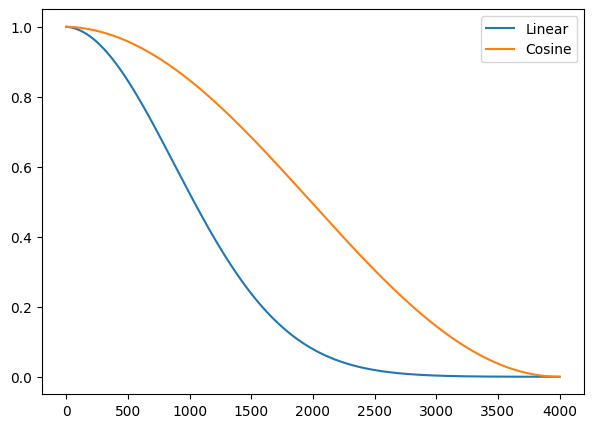

In [39]:
# Plot alpha_cumprod against t/T
T = 4000
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
betas_lin = linear_beta_schedule(T, beta_start=0.0001/4, beta_end=0.02/4)
alphas_cumprod_lin = get_constants(betas_lin)['alphas_cumprod']
t_scaled = torch.linspace(0, T, T)
ax.plot(t_scaled, alphas_cumprod_lin)

alphas_cumprod_cos = cosine_beta_schedule_alphas(T)[:-1]
ax.plot(t_scaled, alphas_cumprod_cos)

# Set legend
ax.legend(['Linear', 'Cosine'])

# Change figure size
fig.set_size_inches(7, 5)

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):

    # Takes in list of (list of) tensor images (1, H, W) and plots them

    # print(type(imgs[0]))
    if isinstance(imgs[0], torch.Tensor):
      imgs = [img.view(img.shape[1], img.shape[2]).cpu().numpy() for img in imgs]
      
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

Linear
Cosine
Quadratic
Sigmoid


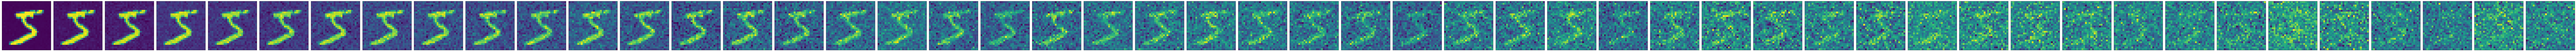

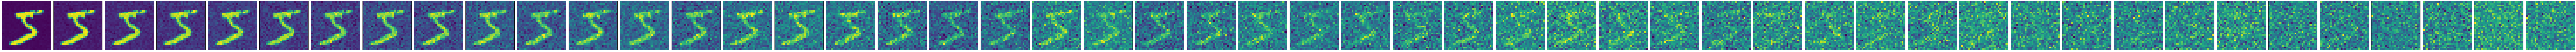

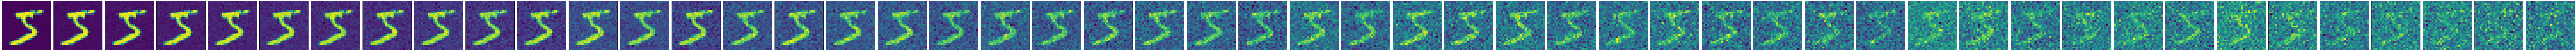

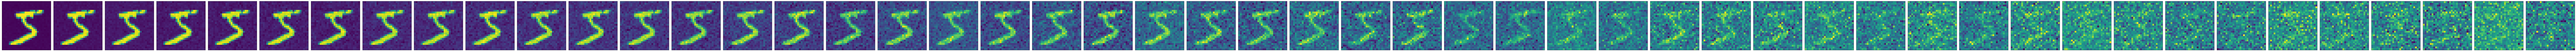

In [66]:
# Get (1, 28, 28) tensor of zeros
import torch.nn.functional as F
n_steps = 50

noised_schedules = []

for b, name in zip([betas_lin, betas_cos, betas_quad, betas_sig], ['Linear', 'Cosine', 'Quadratic', 'Sigmoid']):
    print(name)
    noise_imgs = [q_sample(image, torch.tensor([t]), betas=b) for t in np.linspace(0, T-1, n_steps, dtype=int)]
    noised_schedules.append(noise_imgs)
    plot(noise_imgs)

In [67]:
kl_divs = []

unit_noise = torch.randn_like(image)

for imgs in noised_schedules:
    kl_divs.append([F.kl_div(img, unit_noise, log_target=True, reduction='batchmean').item() for img in imgs])

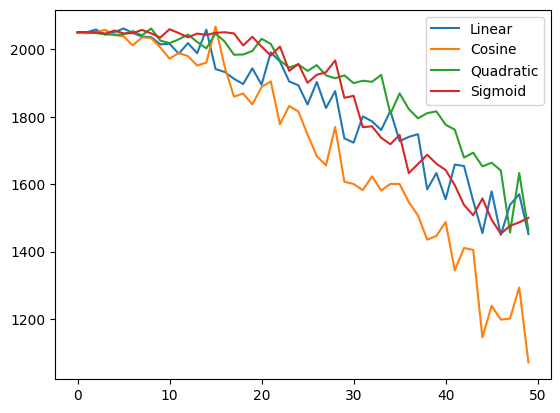

In [68]:
for divs in kl_divs:
    plt.plot(divs)

plt.legend(['Linear', 'Cosine', 'Quadratic', 'Sigmoid']);